# All Ears - CS 545 Final Project & Report

Mikyla Bowen and Nathan Orwick

## Introduction & methodology

The use of biometrics has become increasingly prevalent in daily life. One example of this is security on personal devices. The use of fingerprint readers or Face ID is common and, in many cases, required daily. Interestingly, a person’s ear may also be used for identification and offers some advantages over other forms of biometrics. Facial expressions or facial coverings, for example, wouldn’t be as big a problem as they would be for Face ID.
The motivation for our project was to analyze an ears dataset to determine if we could classify people, apply classification to unseen people (generalization), and classify ears according to their gender. Initially, we hoped to classify right/left ears, but since the meta data was not available, we would have had to tag the data by hand, which was not feasible due to time constraints. Our objectives were to apply models trained from scratch, pretrained models, and augmentations to the dataset to see which combinations were the most successful.

### Dataset
The dataset we used was the EarVN1.0 dataset, which included 28,412 images of 164 different people. This is further broken down into 10,841 images of women and 17,571 images of men. The ears vary in size and resolution, and all subjects are from Vietnam. There is an average of 173 images per person, with 300 as the maximum number of images for a single person and a minimum of 107. The data is structured inside the directory ‘EarVN1.0/Images’, and each folder inside represents a person. Folders are numbered 1-164, and the first 98 are samples of male ears, and the remaining are female ears.

### Methods 
The first experiment uses each person as their own class, resulting in 164 classes. A random guess for this problem would be 0.00609, so our goal was to do better than a random guess. For the other two problems, they were binary classification, so a random guess would be 0.50. Again, the goal was to outperform a random guess. 

For each experiment, we train a scratch model and fine tune a pretrained model. A convolutional neural network seemed like a reasonable baseline since they are powerful for learning important features from images through the cross-correlation (convolutional) layers. Literature for this problem commonly uses CNNs ([journal article one]( https://www.sciencedirect.com/science/article/pii/S1570868316300684) and [journal article two]( https://link.springer.com/article/10.1007/s10489-020-01995-8)), which strengthened our decision to use a simple CNN as a baseline, as we had done for homework three. We chose to compare this CNN baseline with ResNet18, an architecture we learned to use and fine-tune in class. Since we were unsure of how difficult this problem would be, we did not want to immediately throw too complex a network at the problem (like jumping straight to a ResNet-50 or VGG). ResNet18 then seemed a reasonable starting point, especially since we can optionally load pretrained ImageNet weights. If we were to continue this in the future, it would be interesting to try a Vision Transformer since the transformer architecture has been shown to be a strong choice. 

We looked at the validation loss, and made adjustments to the networks: adding more layers, switching loss functions, changing the optimizer, and adjusting the number of epochs. Our analysis looked at accuracy and the confusion matrices. 

### Notebook Structure:
The notebook structure is as follows:
- Shared Functions
- Experiment 1: Classification of Ears by Person
- Experiment 2: Paired Image Recognition
- Experiment 3: Gender Classification
- Conclusion
- Contributions

### [Github](https://github.com/mikylab/all-ears)

Our work was maintained on GitHub, with seperate branches for different experiments and features. The main branch contains the final work with the all-ears.ipynb containing the results for the combined run. Our individual branches still contain our experiments and tests with different code and parameters.

## Experiments & analyses

### Shared imports

In [1]:
from matplotlib import pyplot as plt
import torch
from torch import nn
from torchvision import transforms
import torchvision

import shared_loader
import shared_models
import shared_utils
from shared_utils import device

import pandas as pd

### Shared Functions


Although each experiment required adjusted models and functions, there were some common functions that we were able to move to python files and then import into this notebook. We have three files that are shared and imported: shared_loader.py, shared_models.py, and shared_utils.py

#### shared_loader.py
The shared_loader.py has EarDataset, EarData, and PairedEar classes. The first two classes are used in Experiment 1 and Experiment 3. These functions read in the data according to a pandas csv file that documents person and gender label. It then creates the data loader object with specified parameters. Each image has a label and the dataset is split into train/test based on a stratifed split. 

The PairedEar class: TODO Insert

#### shared_models.py
The shared_models.py has CNNbaseline that has only two convolutional layers and no batch norm, although it does use ReLU as the activation function and uses dropout. This was used in Experiment 1 and 2. The CNNmodified, is built on that, and has additional layers as well as batch normalization. It was used in Experiment 3, for the binary classification, to prevent overfitting. 

PairCNN and PairResnet18 were adaptations of a regular CNN and ResNet desinged to take in pairs of images. 

#### shared_utils.py
This file contained other functions that we called through the training process including: init_cnn, accuracy, model_training, bc_accuracy, bc_model_training, bc_confusion_matrix, and confusionMatix. 

The functions model_training, and bc_model training were both training loops for our models which accepted an initialized model, the dataset, the optimizer, the number of epochs, and allowed for options such as early_stopping, verbose, and finetuning. This is where the models were trained, losses calculated, and accuracy updated. 

The other functions such as confusion matrices allowed us to visualize our results. 

### Run on CUDA if available

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## 1.0 Baseline Experiment: Each Person as a Class

Our original idea was to train the model on data from every person, as a basic classification task where each person is assigned a label. The model must predict which person each ear belongs to in this way. The issue with this is that it does not generalize to new people, which we noted in our proposal. We kept this as an initial task to explore the data space, and our next experiment is the revised version of this.

In [3]:
data_df = pd.read_csv('EarData_df.csv')
data_df

,Path,Person_Label,Name,Gender
0,001.ALI_HD/001 (97).jpg,0,ALI_HD,0
1,001.ALI_HD/001 (200).jpg,0,ALI_HD,0
2,001.ALI_HD/001 (129).jpg,0,ALI_HD,0
3,001.ALI_HD/001 (269).jpg,0,ALI_HD,0
4,001.ALI_HD/001 (22).jpg,0,ALI_HD,0
...,...,...,...,...
28407,164.Yen_Nhi_H/164 (138).jpg,163,Yen_Nhi_H,1
28408,164.Yen_Nhi_H/164 (41).jpg,163,Yen_Nhi_H,1
28409,164.Yen_Nhi_H/164 (83).jpg,163,Yen_Nhi_H,1
28410,164.Yen_Nhi_H/164 (118).jpg,163,Yen_Nhi_H,1


### 1.1 Scratch Model

In [4]:
baseline_data = shared_loader.EarData(data_df, class_label = 1)

baseline_model = shared_models.CNNbaseline()
baseline_model.apply(shared_utils.init_cnn)
baseline_model = baseline_model.to(device)

optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

/usr/local/anaconda3/2023.03/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
baseline_model, baseline_loss_train, baseline_loss_valid, baseline_accuracy_valid = shared_utils.model_training(
    baseline_model, baseline_data, optimizer, loss_fn, epochs=10, early_stopping=False, verbose=True
)
print(f"accuracy: {baseline_accuracy_valid[-1]}")

accuracy: 0.01049440
epoch 10
accuracy: 0.06078980106916001


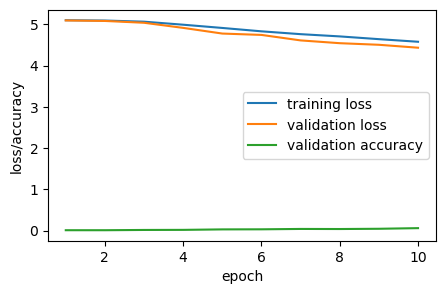

In [36]:
plt.figure(figsize=(5,3))
plt.plot(range(1, len(baseline_loss_train)+1), baseline_loss_train, label='training loss')
plt.plot(range(1, len(baseline_loss_valid)+1), baseline_loss_valid, label='validation loss')
plt.plot(range(1, len(baseline_accuracy_valid)+1), baseline_accuracy_valid, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

### 1.2 ResNet Fine Tuning

In [6]:
finetune_net = torchvision.models.resnet18(weights='IMAGENET1K_V1')
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 164)
nn.init.xavier_uniform_(finetune_net.fc.weight);

finetune_net=finetune_net.to(device)
batch_size=128
param_group=True
learning_rate = 0.001
train_iter = baseline_data.get_dataloader(train=True)
test_iter = baseline_data.get_dataloader(train=False)

loss_fn = nn.CrossEntropyLoss()

if param_group:
    params_1x = [param for name, param in finetune_net.named_parameters() 
                 if name not in ["fc.weight", "fc.bias"]]
    optimizer = torch.optim.SGD([{'params': params_1x},
                                 {'params': finetune_net.fc.parameters(),
                                'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
else:
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                weight_decay=0.001)
    


finetune_net, finetune_loss_train, finetune_loss_valid, finetune_accuracy_valid = shared_utils.model_training(
    finetune_net, baseline_data, optimizer, loss_fn, epochs=10, early_stopping=False, verbose=True, finetune = True
)
print(f"accuracy: {finetune_accuracy_valid[-1]}")


accuracy: 0.02273787
epoch 10
accuracy: 0.29442630597014924


## 1.0 Discussion

For a problem with 164 classes, a random guess would have an accuracy of 0.00609. After 10 epochs, the model achieved 0.06, 10 times better than a random guess, but still not great. Alternatively, the fine tuned network achieved 29% accuracy after 10 epochs, significantly better than a random guess, but still relatively low when the ideal is 100% accuracy.

Our original dataloader, read the data in then split 70/30, which meant the test images were classes that didn't exist in the training data. Obviously, this was not successful and returned accuracy of 0%. Given the goal of generalizability, it was a good showcase that the model did not perform well on the zero-shot problem.

After adjusting the dataloader to split 70/30 per person, the results improved to what is shown above: 6% and 29%. The scratch model did not perform as well on less epochs, but didn't show signs of overfitting with validation loss decreasing with training loss. With additional time running, we expect both models to perform better. However, we did not focus on this extensively, since this experiment was just a baseline for our models and the project idea. Given the limitations of this method to apply to new samples, we then focused on paired ear classification with the hope of recognizing pairs of new images that had not been seen during training. 

## 2.0 Experiment 2: Paired ear classification

To allow for generalization to new people, we can change how the task is set up. To do this, we provide the model with two images, and the model predicts whether the images are from the same person (positive example) or different people (negative example). This allows the model to generalize to new people.

Before setting up the data loader for this experiment, we looked at [Siamese Network Features for Image Matching]( https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7899663&tag=1), which had a similar experimental setup with positive and negative examples. They also referenced [Learning to Match Images in Large-Scale Collections]( https://www.cs.cornell.edu/projects/matchlearn/docs/match_eccv2012ws.pdf) in their dataset section. Key takeaways from looking at these were that pairing all images may be infeasible since it is O(n^2). The team randomly sampled because of this. Pairing images also leads to imbalanced data (toward negative samples), and the paper noted that they chose to keep testing data balanced and use 1.5:1 for negative examples to positive examples.
We tried to aim for this as a starting point, randomly sampling the images and having more negative samples in the training data. This ended up being more difficult than anticipated, especially since we planned to complete our train/test split based on person labels. We split in this way so that people in the training set never show up in the test set, preventing information leakage in that way. This made the data splitting difficult because the exact number of images per person was inconsistent, so achieving the desired ratio involved playing around with random sampling values. The models ended up predicting negative most of the time when we tested this, so we changed to balancing the negative to positive examples 1 to 1.

Another difficulty with the data loading was that pairing images, as the paper mentioned, could explode the data size. Perhaps we did not need to change the example ratios, but instead needed to supply more data to our models. This may have been possible if we had done something like [Torch’s Distributed Data Parallel](https://docs.pytorch.org/tutorials/intermediate/ddp_tutorial.html). Instead of random sampling, we could distribute data across nodes and then synchronize the gradient between epochs.

For model design, we referenced [Pytorch’s Siamese Network Example]( https://github.com/pytorch/examples/blob/main/siamese_network/README.md). This was helpful as it showed a common approach for this type of problem, passing both images through the model for embeddings, then concatenating those to go through a fully connected layer or small multilayer perceptron. We edited our baseline CNN to follow this approach and tested with a ResNet18 (with and without pretrained weights) as well. It’s worth noting that another common approach is to use [TripletLoss]( https://docs.pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html) where examples are not pairs. Instead, they are triples with an anchor image, positive example, and negative example. The PyTorch example noted that this complexity may not always be necessary, so we decided it would be reasonable to start with Binary Cross-Entropy instead of jumping to the more complex variant first.


train_positive=53069
train_negative=78506
val_positive=22206
val_negative=14567
train=106138
val=29134


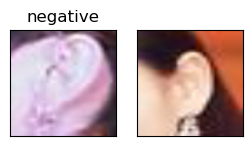

In [7]:
data = shared_loader.PairedEarData(batch_size=128)
batch = next(iter(data.get_dataloader(train=True)))
data.visualize(batch)

#### 2.1 Baseline

In [8]:
model = shared_models.PairCNN()
model.apply(shared_utils.init_cnn)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

In [9]:
model, loss_train, loss_valid, accuracy_valid = shared_utils.bc_model_training(
    model, data, optimizer, loss_fn, epochs=10, early_stopping=False, verbose=True
)
print(f"accuracy: {accuracy_valid[-1]}")

accuracy: 0.52771733
epoch 10
accuracy: 0.5691665327339842


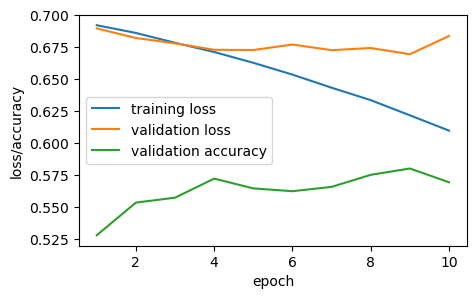

In [10]:
plt.figure(figsize=(5,3))
plt.plot(range(1, len(loss_train)+1), loss_train, label='training loss')
plt.plot(range(1, len(loss_valid)+1), loss_valid, label='validation loss')
plt.plot(range(1, len(loss_valid)+1), accuracy_valid, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

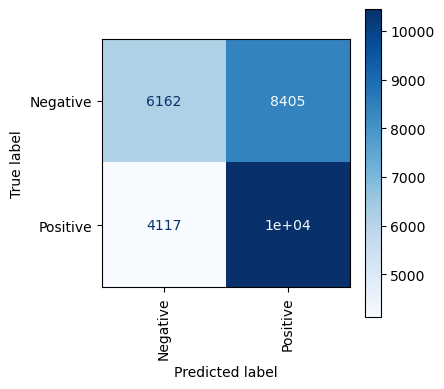

In [11]:
shared_utils.bc_confusion_matrix(data, model, device)

#### 2.2 ResNet18 from scratch

In [12]:
model = shared_models.PairResnet18(pretrained=False)

model.fc.apply(shared_utils.init_cnn)
model = model.to(device)

loss_fn = nn.BCELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0.001)

In [13]:
model, loss_train, loss_valid, accuracy_valid = shared_utils.bc_model_training(
    model, data, optimizer, loss_fn, epochs=10, early_stopping=False, verbose=True
)
print(f"accuracy: {accuracy_valid[-1]}")

accuracy: 0.50522875
epoch 10
accuracy: 0.6068912701387155


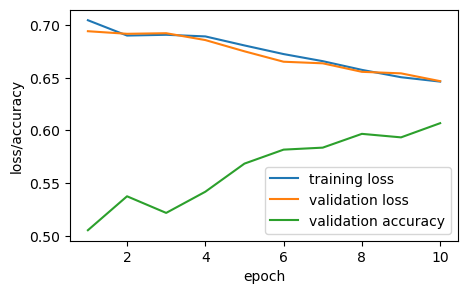

In [14]:
plt.figure(figsize=(5,3))
plt.plot(range(1, len(loss_train)+1), loss_train, label='training loss')
plt.plot(range(1, len(loss_valid)+1), loss_valid, label='validation loss')
plt.plot(range(1, len(loss_valid)+1), accuracy_valid, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

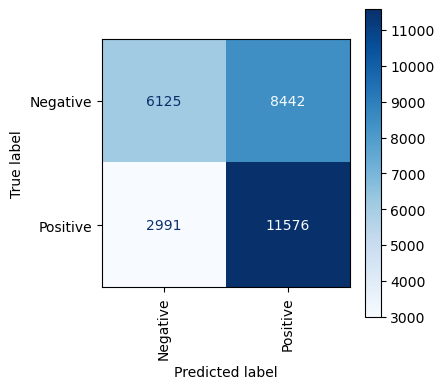

In [15]:
shared_utils.bc_confusion_matrix(data, model, device)

#### 2.3 Pretrained ResNet18 fine tuning

In [16]:
model = shared_models.PairResnet18()

model.fc.apply(shared_utils.init_cnn)
model = model.to(device)

loss_fn = nn.BCELoss()

learning_rate = 0.0001
params_1x = model.resnet.parameters()
params_fc = model.fc.parameters()
optimizer = torch.optim.Adam(
    [{'params': params_1x}, {'params': params_fc, 'lr': learning_rate * 10}],
    lr=learning_rate, weight_decay=0.001
)

In [17]:
model, loss_train, loss_valid, accuracy_valid = shared_utils.bc_model_training(
    model, data, optimizer, loss_fn, epochs=3, early_stopping=False, verbose=True
)
print(f"accuracy: {accuracy_valid[-1]}")

accuracy: 0.62385598
accuracy: 0.6106237635800713


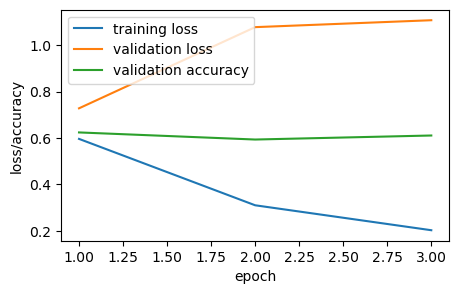

In [18]:
plt.figure(figsize=(5,3))
plt.plot(range(1, len(loss_train)+1), loss_train, label='training loss')
plt.plot(range(1, len(loss_valid)+1), loss_valid, label='validation loss')
plt.plot(range(1, len(loss_valid)+1), accuracy_valid, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

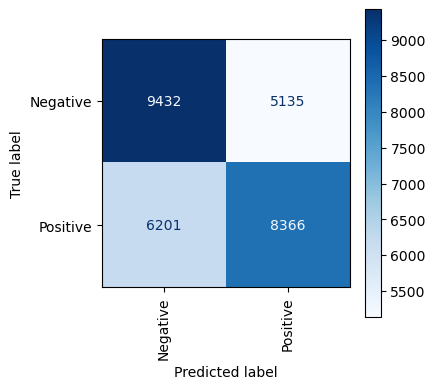

In [19]:
shared_utils.bc_confusion_matrix(data, model, device)

## 2.0 Discussion: Paired ear classification

Will finish in the word doc to be dropped here later

## 3.0 Gender classification

To fully explore the dataset and related problems, we also shifted our objective to classify ears based on their gender. The goal was to see if there was enough information to accurately distinguish ears by [gender](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8401568). There was a slight class imbalance of ~17:10, male: female. The goal of this experiment was also to test the effects of augmentations, to see if that might improve or change gendered characteristics that could fool the classifier.  

### Load in the data with and without augmentations

In [20]:
dataset_augmentations = shared_loader.EarData(data_df, class_label = 3, augmentations = True)
dataset_clean = shared_loader.EarData(data_df, class_label = 3, augmentations = False)


### 3.1 Binary Classification Model from Scratch with no augmentations

In [21]:
binary_model_clean = shared_models.CNNmodified(num_classes=2)
binary_model_clean = binary_model_clean.to(device)

binary_model_clean.apply(shared_utils.init_cnn)

optimizer = torch.optim.Adam(binary_model_clean.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

/usr/local/anaconda3/2023.03/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [22]:
binary_model_clean, binary_clean_loss_train, binary_clean_loss_valid, binary_clean_accuracy_valid = shared_utils.model_training(
    binary_model_clean, dataset_clean, optimizer, loss_fn, epochs=30, early_stopping=False, verbose=True)

accuracy: 0.79326026
epoch 10
accuracy: 0.90543377
epoch 20
accuracy: 0.90788246
epoch 30


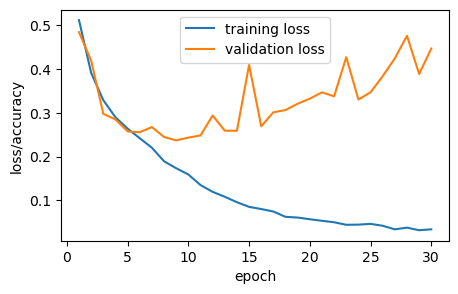

In [23]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(range(1, len(binary_clean_loss_train)+1), binary_clean_loss_train, label='training loss')
plt.plot(range(1, len(binary_clean_loss_valid)+1), binary_clean_loss_valid, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

### 3.2 Binary Classification Model from Scratch with augmentations

In [24]:
binary_model = shared_models.CNNmodified(num_classes=2)
binary_model = binary_model.to(device)

binary_model.apply(shared_utils.init_cnn)

optimizer = torch.optim.Adam(binary_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

binary_model, binary_loss_train, binary_loss_valid, binary_accuracy_valid = shared_utils.model_training(
    binary_model, dataset_augmentations, optimizer, loss_fn, epochs=30, early_stopping=False, verbose=True)

accuracy: 0.75139925
epoch 10
accuracy: 0.87363961
epoch 20
accuracy: 0.90687189
epoch 30


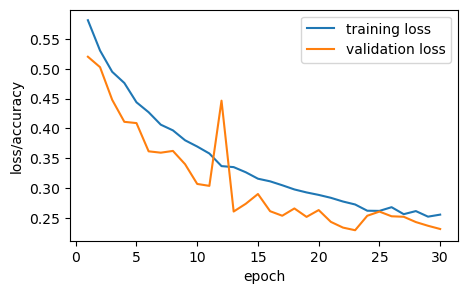

In [25]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(range(1, len(binary_loss_train)+1), binary_loss_train, label='training loss')
plt.plot(range(1, len(binary_loss_valid)+1), binary_loss_valid, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

### 3.3 Binary Classification Model Fine tuned with augmentations

In [26]:
finetune_net = torchvision.models.resnet18(weights='IMAGENET1K_V1')
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

finetune_net=finetune_net.to(device)
batch_size=128
param_group=True
learning_rate = 0.001
train_iter = dataset_augmentations.get_dataloader(train=True)
test_iter = dataset_augmentations.get_dataloader(train=False)

loss_fn = nn.CrossEntropyLoss()

if param_group:
    params_1x = [param for name, param in finetune_net.named_parameters() 
                 if name not in ["fc.weight", "fc.bias"]]
    optimizer = torch.optim.SGD([{'params': params_1x},
                                 {'params': finetune_net.fc.parameters(),
                                'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
else:
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                weight_decay=0.001)
    


finetune_net, finetune_loss_train, finetune_loss_valid, finetune_accuracy_valid = shared_utils.model_training(
    finetune_net, dataset_augmentations, optimizer, loss_fn, epochs=10, early_stopping=False, verbose=True, finetune = True
)
print(f"accuracy: {finetune_accuracy_valid[-1]}")


accuracy: 0.81922419
epoch 10
accuracy: 0.9070662313432836


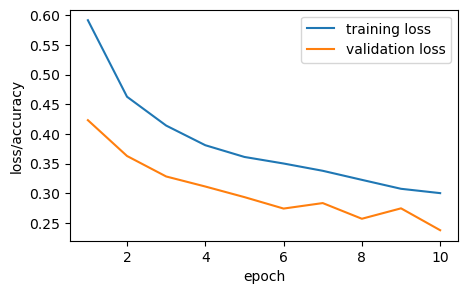

In [27]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(range(1, len(finetune_loss_train)+1), finetune_loss_train, label='training loss')
plt.plot(range(1, len(finetune_loss_valid)+1), finetune_loss_valid, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

### 3.4 Binary Classification Confusion Matrices

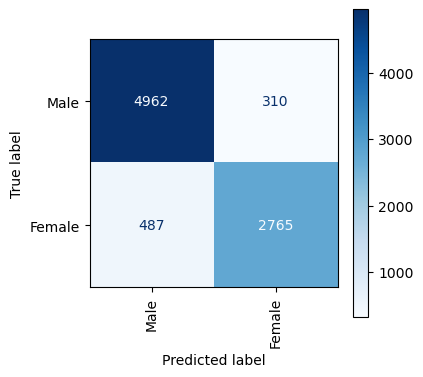

In [33]:
shared_utils.confusionMatrix(dataset_augmentations, finetune_net, device)

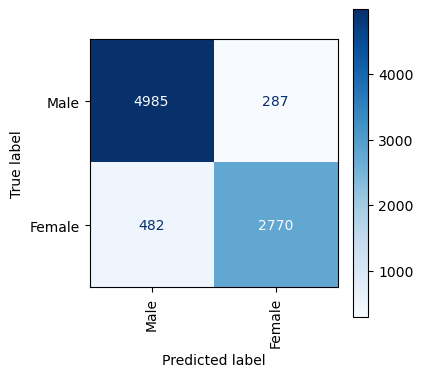

In [34]:
shared_utils.confusionMatrix(dataset_augmentations, binary_model, device)

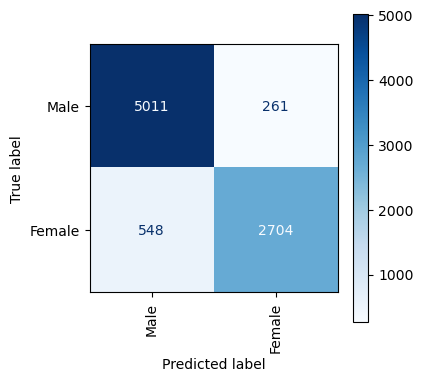

In [35]:
shared_utils.confusionMatrix(dataset_augmentations, binary_model_clean, device)

## 3.0 Gender Classification Discussion

#### Training Notes

My initial work (can be seen in the GitHub Repository), involved creating the dataset within the DataEar loader. This resulted in several problems, namely, how to divide the classes. Since the data was already structured in folders according to person, rather than gender, I had to adjust my logic to make sure the dataset saw images of males and females during training and testing. Originally, I did this by reading in all the data one time and then giving 70% of the data, male or female, to the training and the other 30% to the testing. This is also when I performed data augmentations. 

These code worked and achieved an 89% accuracy. However, it wasn’t the most efficient of pythonic way to read in the data. As a result, I adjusted it to use a PyTorch Dataset and then do a stratified split that would ensure repeatability for the data classes, as well as adjustments to turn on augmentations. 
	
The classification of male vs. female ears resulted in better results than I expected. The scratch model achieved an accuracy of ~88-92% depending on the run. As we saw in class, creating a scratch model doesn’t always yield good results. However, the scratch model performed equally if not better than the finetuned model, highlighting both the difficulty of the problem as well as good choices in model design. In my other experiments (on GitHub), I had severe overfitting. After fixing the data loader issue, I achieved 79%, but by switching to Adam from SGD, I improved it to 89%. The new data loader was also able to achieve slightly better at about ~91-92% accuracy. Initially, I trained for 100 epochs, but after repeated tests, consistent accuracy of 90% was achieved around 30 epochs, with no further improvements. 

#### Analysis

The three models: scratch model with no augmentations, scratch model with augmentations, and the fine-tuned model with augmentations resulted in accuracy in the high 80s to low 90s. However, the scratch models required 30 epochs to achieve that and the fine-tuned network only 10 epochs. The model without augmentations showed signs of overfitting, whereas the model with augmentations had a better performance overall with validation loss continually falling. 

Although accuracy was pretty high, I also investigated the predictions to see what errors the models were making. in 3.4, for each model a confusion matrix is plotted on the validation set with no augmentations. 


| Model    | Male Accuracy |Female Accuracy | Overall Accuracy |
| :-------- | :------- |:------- |:------- |
| Scratch Model without Augmentations  | 95.0%    | 82.2%   |    90.1%    |   
| Scratch Model with Augmentations  | 94.5%    | 85.1%   |   90.9%    |   
| Fine-tuned Model with Augmentations  | 94.1%    | 85.0%   |    90.6%    |    


Overall, the models did well; however, the models did have an over tendency to pick the male image class, instead of the female image class, when the images’ ground truths were female. Alternatively, it rarely chose the image as female if the image’s ground truth was male. 

Although, the model without augmentations had comparable overall accuracy, the class accuracy fell for women from 85% to 82%. The generalizability of the model was not as good for the female class without the augmentations. With perhaps more augmentations or a variety of augmentations this might be improved. A lot of the female images had earrings, so images with might have been more likely to be classified as female and those without as male. Without labeled data on earrings, this is hard to test, so that is both a limitation and question for future work. 

## 4: Conclusion

## 5: Team member contribution

At the end of the notebook, describe team member contributions.

We could probably just make the word doc table a markdown table, maybe this will work: https://tableconvert.com/excel-to-markdown

| Task    | Contribution |Outcome |
| :-------- | :------- |:------- |
| Project Proposal Submission  | MB & NO    | Complete   |
| Data Loader | MB: Baseline/Gendered, <br> NO: Paired    |Complete   |
| Augmentations | MB   |Complete   |
| Paired Ear Recogniztion    | NO   |Complete   |
| Gender Classification | MB|Complete   |
| Analysis | MB & NO|Complete   |
| Documentation | MB & NO|Complete   |